In [2]:
import sys
sys.path.append('.')

import numpy as np

from annotation_ems.gen_dataset import generate_dataset
from annotation_ems.ems_prepare import split, prepare_json
import itertools as it

import subprocess
import os
import time
import random

### begin of config

dataset_path = '/mnt/data/yxchen/gesture-datasets/ems'
output_path = './annotation_ems/'

expr_name_train = "crossval0003_train" # Name of trained model
expr_name_test = "crossval0003_test"   # Name of testing script
modality = "rgb"  # d, rgb, rgbd
labels = ['wrist_left', 'wrist_right', 'pronation', 'supination']

In [3]:
# Put your entire list of datasets here
data_batch = ['subject01_machine_recovery_3gps_2pairs', \
              'subject01_machine_recovery_3gps_2pairs_03', \
              'subject01_machine_recovery_3gps_2pairs_04', \
              'subject01_machine_recovery_3gps_2pairs_05', \
              'subject01_machine_recovery_3gps_2pairs_06', 
              'subject03_03']
#data_batch = [6,5,4,3,2,1]
data_batch.sort()

In [4]:
data_batch

['subject01_machine_recovery_3gps_2pairs',
 'subject01_machine_recovery_3gps_2pairs_03',
 'subject01_machine_recovery_3gps_2pairs_04',
 'subject01_machine_recovery_3gps_2pairs_05',
 'subject01_machine_recovery_3gps_2pairs_06',
 'subject03_03']

In [5]:
instance_ratio = 5  # Number of datasets used for training
combinations = list(it.combinations(data_batch, instance_ratio))

In [6]:
combinations # Possible combinations of datasets

[('subject01_machine_recovery_3gps_2pairs',
  'subject01_machine_recovery_3gps_2pairs_03',
  'subject01_machine_recovery_3gps_2pairs_04',
  'subject01_machine_recovery_3gps_2pairs_05',
  'subject01_machine_recovery_3gps_2pairs_06'),
 ('subject01_machine_recovery_3gps_2pairs',
  'subject01_machine_recovery_3gps_2pairs_03',
  'subject01_machine_recovery_3gps_2pairs_04',
  'subject01_machine_recovery_3gps_2pairs_05',
  'subject03_03'),
 ('subject01_machine_recovery_3gps_2pairs',
  'subject01_machine_recovery_3gps_2pairs_03',
  'subject01_machine_recovery_3gps_2pairs_04',
  'subject01_machine_recovery_3gps_2pairs_06',
  'subject03_03'),
 ('subject01_machine_recovery_3gps_2pairs',
  'subject01_machine_recovery_3gps_2pairs_03',
  'subject01_machine_recovery_3gps_2pairs_05',
  'subject01_machine_recovery_3gps_2pairs_06',
  'subject03_03'),
 ('subject01_machine_recovery_3gps_2pairs',
  'subject01_machine_recovery_3gps_2pairs_04',
  'subject01_machine_recovery_3gps_2pairs_05',
  'subject01_mach

In [7]:
# Prepare annotation for dataset

train_ratio = 100   # How much percent if for training
test_ratio = 0      # How much percent is not for testing
count = 1

for combination in combinations:
    name = '000%d' % count if (count < 10) else \
    ('00%d' % count if count <100 else \
    ('0%d' % count if count < 1000 else \
    ('%d' %count)))
    print(expr_name_train+name)
    #print(combination)
    training_data = list(combination)
    train_partition = { i : train_ratio for i in training_data }
    testing_data = list(set(data_batch) - set(combination))
    test_partition = { }
    ### end of config
    generate_dataset(expr_name=expr_name_train+name, modality=modality, dataset_path=dataset_path, output_path=output_path, train_partition=train_partition, test_partition=test_partition, labels=labels)
    prepare_json(csv_dir_path=output_path, expr_name=expr_name_train+name)
    count += 1

count = 1
for dataset in data_batch:
    name = '000%d' % count if (count <= 10) else \
    ('00%d' % count if count <=100 else \
    ('0%d' % count if count <= 1000 else \
    ('%d' %count)))
    print(expr_name_test+name)
    train_partition = { }    
    test_partition = {dataset: test_ratio}
    generate_dataset(expr_name=expr_name_test+name, modality=modality, dataset_path=dataset_path, output_path=output_path, train_partition=train_partition, test_partition=test_partition, labels=labels)
    prepare_json(csv_dir_path=output_path, expr_name=expr_name_test+name)
    count += 1

crossval0003_train0001
crossval0003_train0002
crossval0003_train0003
crossval0003_train0004
crossval0003_train0005
crossval0003_train0006
crossval0003_test0001
crossval0003_test0002
crossval0003_test0003
crossval0003_test0004
crossval0003_test0005
crossval0003_test0006


In [9]:
# Train all the combination models
count = 1
processes = set()
max_processes = 2   # Number of processes to run in parallel at a time

for combination in combinations:
    if (count != 3 and count != 6):
        count += 1
        continue
    name = '000%d' % count if (count < 10) else \
        ('00%d' % count if count <100 else \
        ('0%d' % count if count < 1000 else \
        ('%d' %count)))
    cmd = "CUDA_VISIBLE_DEVICES=%d nohup python main.py \
        --root_path /mnt/data/jarvislam1999/Real-time-GesRec \
        --video_path %s \
        --annotation_path annotation_ems/ems%s.json\
        --result_path results/ems%s \
        --pretrain_path /mnt/data/yxchen/model-zoo/jester_resnext_101_RGB_32.pth \
        --dataset ems \
        --sample_duration 32 \
        --learning_rate 0.01 \
        --model resnext \
        --model_depth 101 \
        --resnet_shortcut B \
        --batch_size 12 \
        --n_classes 27 \
        --n_finetune_classes 4 \
        --n_threads 16 \
        --checkpoint 1 \
        --modality RGB \
        --train_crop random \
        --n_val_samples 1 \
        --test_subset test \
        --n_epochs 40 \
        --no_val \
        --checkpoint 5\
    " % ((count-1) % 2,dataset_path, expr_name_train+name,expr_name_train+name)
    print(expr_name_train+name)
    out = open('ems%sout.txt'%(expr_name_train+name), 'w')
    processes.add(subprocess.Popen(cmd, shell=True, stdout = out, stderr = out))
    #print(processes)
    count += 1
    if len(processes) >= max_processes:
        os.wait()
        processes.difference_update(
            [p for p in processes if p.poll() is not None])
        
#Check if all the child processes were closed
for p in processes:
    if p.poll() is None:
        p.wait()

crossval0003_train0003
crossval0003_train0006


In [11]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "%d" % random.randrange(0,4)

import sys
# sys.path.append('../')
os.chdir("/mnt/data/jarvislam1999/Real-time-GesRec/")

from ems_tester import EMSTester

In [12]:
# Test all the datasets against the models
accuracy_dict = {}
count_train = 1
for combination in combinations:
    name_train = '000%d' % count_train if (count_train < 10) else \
            ('00%d' % count_train if count_train <100 else \
            ('0%d' % count_train if count_train < 1000 else \
            ('%d' %count_train)))
    print(name_train)
    training_data = list(combination)
    train_partition = { i : train_ratio for i in training_data }
    testing_data = list(set(data_batch) - set(combination))
    
    accuracy_list = []
    count_test = 1
    for dataset in data_batch:
        name_test = '000%d' % count_test if (count_test <= 10) else \
            ('00%d' % count_test if count_test <=100 else \
            ('0%d' % count_test if count_test <= 1000 else \
            ('%d' %count_test)))
        print(name_test)
        tester = EMSTester(root_path='/mnt/data/jarvislam1999/Real-time-GesRec',
                  video_path='/mnt/data/yxchen/gesture-datasets/ems',
                  annotation_path='annotation_ems/ems%s.json' % (expr_name_test+name_test),
                  result_path='results/ems%s_test' % (expr_name_test+name_test),
                  model_path='results/ems%s/save_30.pth' %(expr_name_train+name_train))
        y_pred, y_true, test_data = tester.test()
        if dataset in training_data:
            accuracy_list.append(- np.sum(np.equal(y_pred, y_true))/len(y_pred)*100)
        elif (dataset in testing_data):
            accuracy_list.append(np.sum(np.equal(y_pred, y_true))/len(y_pred)*100)
        count_test+=1
    accuracy_dict[expr_name_train+name_train] = accuracy_list
    count_train +=1
    
    

0001
0001
Namespace(annotation_path='/mnt/data/jarvislam1999/Real-time-GesRec/annotation_ems/emscrossval0003_test0001.json', arch='resnext-101', batch_size=1, begin_epoch=1, checkpoint=1, crop_position_in_test='c', dampening=0.9, dataset='ems', ft_begin_index=0, initial_scale=1.0, learning_rate=0.1, lr_patience=10, lr_steps=[10, 25, 50, 80, 100], manual_seed=1, mean=[114.7748, 107.7354, 99.475], mean_dataset='activitynet', modality='RGB', model='resnext', model_depth=101, momentum=0.9, n_classes=400, n_epochs=200, n_finetune_classes=4, n_scales=5, n_threads=1, n_val_samples=1, nesterov=False, no_cuda=False, no_hflip=False, no_mean_norm=False, no_softmax_in_test=False, no_train=False, no_val=False, norm_value=1, optimizer='sgd', pretrain_path='', resnet_shortcut='B', resnext_cardinality=32, result_path='/mnt/data/jarvislam1999/Real-time-GesRec/results/emscrossval0003_test0001_test', resume_path='/mnt/data/jarvislam1999/Real-time-GesRec/results/emscrossval0003_train0001/save_30.pth', roo

[INFO]: RGB model is used for init model
Total number of trainable parameters:  47529412
[INFO]: EMS Dataset - testing is loading...
dataset loading [0/400]
loading checkpoint /mnt/data/jarvislam1999/Real-time-GesRec/results/emscrossval0003_train0001/save_30.pth
Batch time: 0
Batch time: 0.15682799816131593
-----Evaluation is finished------
Overall Prec@1 100.00000%
0006
Namespace(annotation_path='/mnt/data/jarvislam1999/Real-time-GesRec/annotation_ems/emscrossval0003_test0006.json', arch='resnext-101', batch_size=1, begin_epoch=1, checkpoint=1, crop_position_in_test='c', dampening=0.9, dataset='ems', ft_begin_index=0, initial_scale=1.0, learning_rate=0.1, lr_patience=10, lr_steps=[10, 25, 50, 80, 100], manual_seed=1, mean=[114.7748, 107.7354, 99.475], mean_dataset='activitynet', modality='RGB', model='resnext', model_depth=101, momentum=0.9, n_classes=400, n_epochs=200, n_finetune_classes=4, n_scales=5, n_threads=1, n_val_samples=1, nesterov=False, no_cuda=False, no_hflip=False, no_me

[INFO]: RGB model is used for init model
Total number of trainable parameters:  47529412
[INFO]: EMS Dataset - testing is loading...
dataset loading [0/400]
loading checkpoint /mnt/data/jarvislam1999/Real-time-GesRec/results/emscrossval0003_train0002/save_30.pth
Batch time: 0
Batch time: 0.2070222669839859
-----Evaluation is finished------
Overall Prec@1 99.50000%
0005
Namespace(annotation_path='/mnt/data/jarvislam1999/Real-time-GesRec/annotation_ems/emscrossval0003_test0005.json', arch='resnext-101', batch_size=1, begin_epoch=1, checkpoint=1, crop_position_in_test='c', dampening=0.9, dataset='ems', ft_begin_index=0, initial_scale=1.0, learning_rate=0.1, lr_patience=10, lr_steps=[10, 25, 50, 80, 100], manual_seed=1, mean=[114.7748, 107.7354, 99.475], mean_dataset='activitynet', modality='RGB', model='resnext', model_depth=101, momentum=0.9, n_classes=400, n_epochs=200, n_finetune_classes=4, n_scales=5, n_threads=1, n_val_samples=1, nesterov=False, no_cuda=False, no_hflip=False, no_mean

[INFO]: RGB model is used for init model
Total number of trainable parameters:  47529412
[INFO]: EMS Dataset - testing is loading...
dataset loading [0/400]
loading checkpoint /mnt/data/jarvislam1999/Real-time-GesRec/results/emscrossval0003_train0003/save_30.pth
Batch time: 0
Batch time: 0.20791415631771087
-----Evaluation is finished------
Overall Prec@1 100.00000%
0004
Namespace(annotation_path='/mnt/data/jarvislam1999/Real-time-GesRec/annotation_ems/emscrossval0003_test0004.json', arch='resnext-101', batch_size=1, begin_epoch=1, checkpoint=1, crop_position_in_test='c', dampening=0.9, dataset='ems', ft_begin_index=0, initial_scale=1.0, learning_rate=0.1, lr_patience=10, lr_steps=[10, 25, 50, 80, 100], manual_seed=1, mean=[114.7748, 107.7354, 99.475], mean_dataset='activitynet', modality='RGB', model='resnext', model_depth=101, momentum=0.9, n_classes=400, n_epochs=200, n_finetune_classes=4, n_scales=5, n_threads=1, n_val_samples=1, nesterov=False, no_cuda=False, no_hflip=False, no_me

[INFO]: RGB model is used for init model
Total number of trainable parameters:  47529412
[INFO]: EMS Dataset - testing is loading...
dataset loading [0/400]
loading checkpoint /mnt/data/jarvislam1999/Real-time-GesRec/results/emscrossval0003_train0004/save_30.pth
Batch time: 0
Batch time: 0.21067550480365754
-----Evaluation is finished------
Overall Prec@1 100.00000%
0003
Namespace(annotation_path='/mnt/data/jarvislam1999/Real-time-GesRec/annotation_ems/emscrossval0003_test0003.json', arch='resnext-101', batch_size=1, begin_epoch=1, checkpoint=1, crop_position_in_test='c', dampening=0.9, dataset='ems', ft_begin_index=0, initial_scale=1.0, learning_rate=0.1, lr_patience=10, lr_steps=[10, 25, 50, 80, 100], manual_seed=1, mean=[114.7748, 107.7354, 99.475], mean_dataset='activitynet', modality='RGB', model='resnext', model_depth=101, momentum=0.9, n_classes=400, n_epochs=200, n_finetune_classes=4, n_scales=5, n_threads=1, n_val_samples=1, nesterov=False, no_cuda=False, no_hflip=False, no_me

[INFO]: RGB model is used for init model
Total number of trainable parameters:  47529412
[INFO]: EMS Dataset - testing is loading...
dataset loading [0/398]
loading checkpoint /mnt/data/jarvislam1999/Real-time-GesRec/results/emscrossval0003_train0005/save_30.pth
Batch time: 0
Batch time: 0.20684134301228738
-----Evaluation is finished------
Overall Prec@1 100.00000%
0002
Namespace(annotation_path='/mnt/data/jarvislam1999/Real-time-GesRec/annotation_ems/emscrossval0003_test0002.json', arch='resnext-101', batch_size=1, begin_epoch=1, checkpoint=1, crop_position_in_test='c', dampening=0.9, dataset='ems', ft_begin_index=0, initial_scale=1.0, learning_rate=0.1, lr_patience=10, lr_steps=[10, 25, 50, 80, 100], manual_seed=1, mean=[114.7748, 107.7354, 99.475], mean_dataset='activitynet', modality='RGB', model='resnext', model_depth=101, momentum=0.9, n_classes=400, n_epochs=200, n_finetune_classes=4, n_scales=5, n_threads=1, n_val_samples=1, nesterov=False, no_cuda=False, no_hflip=False, no_me

[INFO]: RGB model is used for init model
Total number of trainable parameters:  47529412
[INFO]: EMS Dataset - testing is loading...
dataset loading [0/400]
loading checkpoint /mnt/data/jarvislam1999/Real-time-GesRec/results/emscrossval0003_train0005/save_30.pth
Batch time: 0
Batch time: 0.23901120245456695
-----Evaluation is finished------
Overall Prec@1 100.00000%
0006
0001
Namespace(annotation_path='/mnt/data/jarvislam1999/Real-time-GesRec/annotation_ems/emscrossval0003_test0001.json', arch='resnext-101', batch_size=1, begin_epoch=1, checkpoint=1, crop_position_in_test='c', dampening=0.9, dataset='ems', ft_begin_index=0, initial_scale=1.0, learning_rate=0.1, lr_patience=10, lr_steps=[10, 25, 50, 80, 100], manual_seed=1, mean=[114.7748, 107.7354, 99.475], mean_dataset='activitynet', modality='RGB', model='resnext', model_depth=101, momentum=0.9, n_classes=400, n_epochs=200, n_finetune_classes=4, n_scales=5, n_threads=1, n_val_samples=1, nesterov=False, no_cuda=False, no_hflip=False, 

[INFO]: RGB model is used for init model
Total number of trainable parameters:  47529412
[INFO]: EMS Dataset - testing is loading...
dataset loading [0/400]
loading checkpoint /mnt/data/jarvislam1999/Real-time-GesRec/results/emscrossval0003_train0006/save_30.pth
Batch time: 0
Batch time: 0.20268070757389067
-----Evaluation is finished------
Overall Prec@1 100.00000%
0006
Namespace(annotation_path='/mnt/data/jarvislam1999/Real-time-GesRec/annotation_ems/emscrossval0003_test0006.json', arch='resnext-101', batch_size=1, begin_epoch=1, checkpoint=1, crop_position_in_test='c', dampening=0.9, dataset='ems', ft_begin_index=0, initial_scale=1.0, learning_rate=0.1, lr_patience=10, lr_steps=[10, 25, 50, 80, 100], manual_seed=1, mean=[114.7748, 107.7354, 99.475], mean_dataset='activitynet', modality='RGB', model='resnext', model_depth=101, momentum=0.9, n_classes=400, n_epochs=200, n_finetune_classes=4, n_scales=5, n_threads=1, n_val_samples=1, nesterov=False, no_cuda=False, no_hflip=False, no_me

In [13]:
accuracy_dict

{'crossval0003_train0001': [-100.0,
  -100.0,
  -100.0,
  -99.75,
  -100.0,
  61.750000000000007],
 'crossval0003_train0002': [-100.0, -99.75, -100.0, -99.5, 97.5, -100.0],
 'crossval0003_train0003': [-100.0, -99.75, -100.0, 95.0, -100.0, -100.0],
 'crossval0003_train0004': [-100.0, -100.0, 98.5, -99.75, -100.0, -100.0],
 'crossval0003_train0005': [-100.0, 73.25, -100.0, -99.75, -100.0, -100.0],
 'crossval0003_train0006': [95.477386934673376,
  -100.0,
  -100.0,
  -99.5,
  -100.0,
  -100.0]}

('subject01_machine_recovery_3gps_2pairs', 'subject01_machine_recovery_3gps_2pairs_03', 'subject01_machine_recovery_3gps_2pairs_04', 'subject01_machine_recovery_3gps_2pairs_05', 'subject01_machine_recovery_3gps_2pairs_06', 'subject03_03')
[-100.0, 73.25, -100.0, -99.75, -100.0, -100.0]


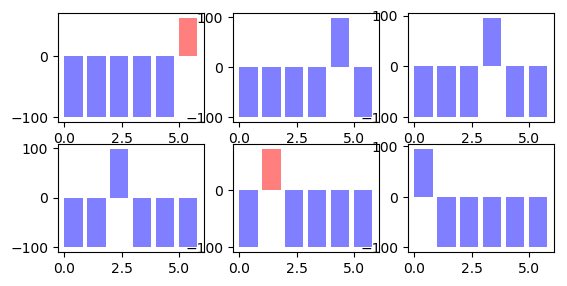

In [14]:
# Visualize the performance

import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = tuple(data_batch)
y_pos = np.arange(len(objects))
performance = accuracy_dict[expr_name_train+'0005']
print(objects)
print(performance)

#plt.subplot(111)
count = 1
for combination in combinations:
    name = '000%d' % count if (count < 10) else \
        ('00%d' % count if count <100 else \
        ('0%d' % count if count < 1000 else \
        ('%d' %count)))
    #objects = tuple([""]*len(objects))
    y_pos = np.arange(len(objects))
    performance = accuracy_dict[expr_name_train+name]
    greater = np.logical_or(np.greater(0, performance),\
                             np.greater(performance, 90))
    color = ["b" if x else "r" for x in greater]
    plt.subplot(len(objects) // 3 + 1,3,count)
    plt.bar(y_pos, performance, align='edge', alpha=0.5,color = color)

    #plt.xticks(y_pos, objects)
    #plt.ylabel('Performance')
    #plt.title('Test data')
    count += 1

plt.show()